(2049, 2049) (2049, 2049)


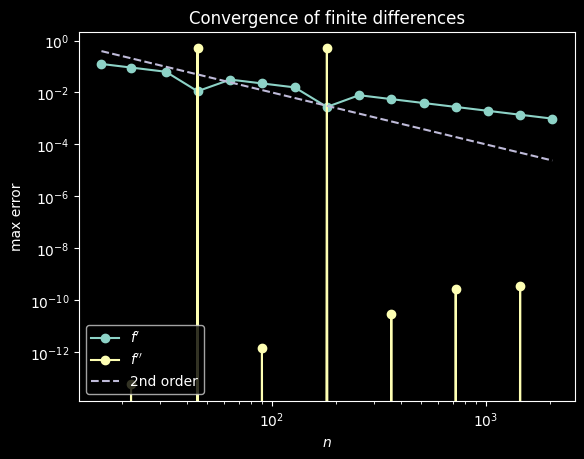

In [1]:
#10.3.1
from numpy import *
from matplotlib.pyplot import *

def diffmat2(n, xspan):
    """
    diffmat2(n, xspan)

    Compute 2nd-order-accurate differentiation matrices on n+1 points in the
    interval xspan. Return a vector of nodes, and the matrices for the first
    and second derivatives.
    """
    a, b = xspan
    h = (b - a) / n
    x = linspace(a, b, n + 1)  # nodes

    # Define most of Dx by its diagonals.
    dp = 0.5 / h * ones(n)  # superdiagonal
    dm = -0.5 / h * ones(n)  # subdiagonal
    Dx = diag(dm, -1) + diag(dp, 1)

    # Fix first and last rows.
    Dx[0, :3] = array([-1.5, 2, -0.5]) / h
    Dx[-1, -3:] = array([0.5, -2, 1.5]) / h

    # Define most of Dxx by its diagonals.
    d0 = -2 / h**2 * ones(n + 1)  # main diagonal
    dp = ones(n) / h**2  # superdiagonal and subdiagonal
    Dxx = diag(d0, 0) + diag(dp, -1) + diag(dp, 1)

    # Fix first and last rows.
    Dxx[0, :4] = array([2, -5, 4, -1]) / h**2
    Dxx[-1, -4:] = array([-1, 4, -5, 2]) / h**2

    return x, Dx, Dxx

f = lambda x: sign(x) * x**2
df_dx = lambda x: sign(x) * 2 * x
d2f_dx2 = lambda x: sign(x) * 2

t, Dx, _ = diffmat2(12, [-1, 1])
Dxx = Dx**2
y = f(t)

yx = Dx @ y
yxx = Dxx @ y
'''
x = linspace(-1, 1, 500)
subplot(2, 1, 1)
plot(x, df_dx(x))
plot(t, yx, "o")
xlabel("$x$"),  ylabel("$f'(x)$")

subplot(2, 1, 2)
plot(x, d2f_dx2(x))
plot(t, yxx, "o")
xlabel("$x$"),  ylabel("$f''(x)$");
'''
N = array([int(2**k) for k in arange(4, 11.5, 0.5)])
err1 = zeros(len(N))
err2 = zeros(len(N))
for k, n in enumerate(N):
    t, Dx, Dxx = diffmat2(n, [-1, 1])
    y = f(t)
    err1[k] = linalg.norm(df_dx(t) - Dx @ y, inf)
    err2[k] = linalg.norm(d2f_dx2(t) - Dxx @ y, inf)

loglog(N, err1, "-o", label="$f'$")
loglog(N, err2, "-o", label="$f''$")
plot(N, 10 * 10 / N**2, "--", label="2nd order")
xlabel("$n$"),  ylabel("max error")
legend(loc="lower left")
title("Convergence of finite differences");


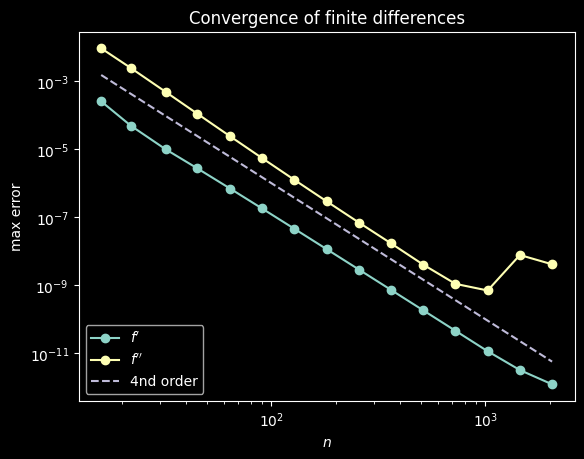

In [5]:
#10.3.3
import numpy as np

def fdweights(t, m):
    """
    fdweights(t, m)

    Return weights for the mth derivative of a function at zero using values at the
    nodes in vector t.
    """
    # This is a compact implementation, not an efficient one.

    def weight(t, m, r, k):
        # Recursion for one weight.
        # Input:
        #   t   nodes (vector)
        #   m   order of derivative sought
        #   r   number of nodes to use from t (<= length(t))
        #   k   index of node whose weight is found

        if (m < 0) or (m > r):  # undefined coeffs must be zero
            c = 0
        elif (m == 0) and (r == 0):  # base case of one-point interpolation
            c = 1
        else:  # generic recursion
            if k < r:
                denom = t[r] - t[k]
                c = (t[r] * weight(t, m, r-1, k) - m * weight(t, m-1, r-1, k)) / denom
            else:
                beta = np.prod(t[r-1] - t[:r-1]) / np.prod(t[r] - t[:r])
                c = beta * (m * weight(t, m-1, r-1, r-1) - t[r-1] * weight(t, m, r-1, r-1))
        return c

    r = len(t) - 1
    w = np.zeros(t.shape)
    return np.array([ weight(t, m, r, k) for k in range(r+1) ])

def diffmat4(n, xspan):
    a, b = xspan
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)

    Dx = np.zeros((n + 1, n + 1))
    Dxx = np.zeros((n + 1, n + 1))

    for i in range(2, n - 1):
        nodes = x[i-2 : i+3]
        t = nodes - x[i]

        w1 = fdweights(t, 1) # 一阶导权重
        w2 = fdweights(t, 2) # 二阶导权重

        Dx[i, i-2 : i+3] = w1
        Dxx[i, i-2 : i+3] = w2

    n_boundary = 6

    for i in [0, 1]:
        nodes = x[0 : n_boundary]
        t = nodes - x[i]

        Dx[i, 0 : n_boundary]  = fdweights(t, 1)
        Dxx[i, 0 : n_boundary] = fdweights(t, 2)

    for i in [n - 1, n]:
        nodes = x[-n_boundary:]
        t = nodes - x[i]

        Dx[i, -n_boundary:]  = fdweights(t, 1)
        Dxx[i, -n_boundary:] = fdweights(t, 2)

    return x, Dx, Dxx

f = lambda x: np.exp(np.sin(x))
df_dx = lambda x: np.cos(x) * np.exp(np.sin(x))
d2f_dx2 = lambda x: (np.cos(x)**2 - np.sin(x)) * np.exp(np.sin(x))

t, Dx, _ = diffmat2(12, [-1, 1])
Dxx = Dx**2
y = f(t)

yx = Dx @ y
yxx = Dxx @ y

N = array([int(2**k) for k in arange(4, 11.5, 0.5)])
err1 = zeros(len(N))
err2 = zeros(len(N))
for k, n in enumerate(N):
    t, Dx, Dxx = diffmat4(n, [-1, 1])
    y = f(t)
    err1[k] = linalg.norm(df_dx(t) - Dx @ y, inf)
    err2[k] = linalg.norm(d2f_dx2(t) - Dxx @ y, inf)

loglog(N, err1, "-o", label="$f'$")
loglog(N, err2, "-o", label="$f''$")
plot(N, 10 * 10 / N**4, "--", label="4nd order")
xlabel("$n$"),  ylabel("max error")
legend(loc="lower left")
title("Convergence of finite differences");

